In [122]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser

In [123]:
fc = FileChooser('../benchmarks/rent_files')
display(fc)

FileChooser(path='/home/marieke/GNL_clone/benchmarks/rent_files', filename='', title='', show_hidden=False, se…

In [124]:
rent_path = fc.value
with open(rent_path, "rb") as fp:   # Unpickling
    rent_data = pickle.load(fp)

In [125]:
rent_data
for level in rent_data:
    print(len(level))

1
2
4
8
16
32
64
128
256
512
1024
1598
328
14


In [126]:
rent_data_flat = np.array([data_point for level in rent_data for data_point in level])

In [127]:
blocks = np.array(rent_data_flat)[:,0]
pins = np.array(rent_data_flat)[:,1]

### bin data

In [128]:
n_bins = 13

max_blocks = max(blocks)
max_blocks

3406

In [129]:
bin_factor = max_blocks**(1/(n_bins))
bin_values = []
bin_value = 1
for i in range(n_bins):
    bin_value*=bin_factor
    bin_values.append(bin_value)
bin_values[-1] += 1

In [130]:
#Sort on first column (blocks)
rent_data_flat = rent_data_flat[rent_data_flat[:,0].argsort()]

In [131]:
binned_data = []
sorted_mask = np.array([False]*len(rent_data_flat))
for bin_value in bin_values:
    bin_mask = rent_data_flat[:,0] <= bin_value
    bin_mask = bin_mask ^ sorted_mask
    binned_data.append(rent_data_flat[bin_mask])
    sorted_mask = sorted_mask | bin_mask
assert len(sorted_mask) == sorted_mask.sum()

In [132]:
bin_means = []
bin_stds = []
for data in binned_data:
    blocks_mean = data[:,0].mean()
    pins_mean = np.median(data[:,1])
    bin_means.append([blocks_mean, pins_mean])
    bin_stds.append(data[:,1].std())
bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)

### Visualise data

array([  16.1824069 ,   22.95726798,   34.11762644,   53.99674243,
         72.1778925 ,   97.02551321,  123.22931456,  202.05536614,
        282.27053042,  374.91897041,  386.56467764,   22.5       ,
       1289.5       ])

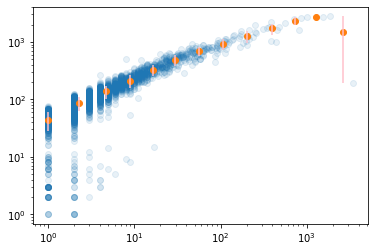

In [133]:
plt.xscale("log")
plt.yscale("log")
plt.scatter(blocks, pins, alpha = 0.1)
plt.scatter(bin_means[:,0], bin_means[:,1])

plt.vlines(bin_means[:,0], bin_means[:,1] - bin_stds, bin_means[:,1]+bin_stds, colors='pink')

bin_stds

In [134]:
len(blocks)

3987

### Find rent exponent

In [135]:
log_bin_means = np.log(bin_means)
#TODO: hoe stds weergeven op logaritmisch schaal (hierboven ook niet echt correct? )
log_bin_stds = np.log(bin_stds)
log_bin_stds

array([2.78392466, 3.13363457, 3.52981416, 3.98892372, 4.2791338 ,
       4.57497397, 4.81404697, 5.30854175, 5.64286594, 5.92670992,
       5.9572992 , 3.11351531, 7.16200983])

In [143]:
#TODO: geef gewicht aan bins .. op minder punten --> meer onzekerheid .. 
def trend_line(data):
    x = data[:,0]
    y = data[:,1]
    x_mean = x.mean()
    y_mean = y.mean()
    x_err = x-x_mean
    y_err = y-y_mean
    a = (x_err*y_err).sum()/ ((x_err)**2).sum()
    b = y_mean - x_mean*a
    first_point = [x[0], x[0]*a + b]
    last_point = [x[-1], x[-1]*a + b]
    
    #Error
    error = sum((y - (x*a + b))**2)/len(data)   
    
    return np.array([first_point, last_point]), a, b, error

In [144]:
trend_line(log_bin_means[:])

(array([[0.        , 4.20725511],
        [7.8785342 , 8.2174469 ]]),
 0.5090022698594517,
 4.207255114616013,
 0.10738229800281388)

In [145]:
int(n_bins/2)
n_selected_bins = 6
error_per_n_bins = [] ##Find the best error for sliding windows of selected number of bins
for n_selected_bins in range(int(3), n_bins+1):
    print(n_selected_bins)
    min_error = np.inf
    min_error_data = []
    for i in range(n_bins-n_selected_bins+1):
        line, slope, offset, error = trend_line(log_bin_means[i:i+n_selected_bins])
        if error < min_error:
            min_error = error
            min_error_data = log_bin_means[i:i+n_selected_bins]
    error_per_n_bins.append([n_selected_bins, min_error_data, min_error]) 
error_per_n_bins = np.array(error_per_n_bins, dtype=object)

3
4
5
6
7
8
9
10
11
12
13


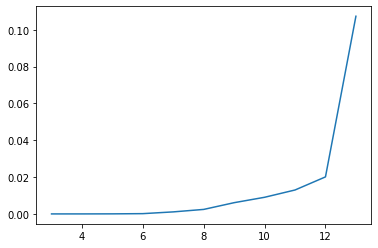

In [146]:
plt.plot(error_per_n_bins[:, 0], error_per_n_bins[:, -1])

In [147]:
error_per_n_bins[:, -1]

array([6.766946607669602e-08, 4.062823366107343e-06,
       3.583938807100603e-05, 0.00014915454911112487,
       0.001103046313536358, 0.00244672869971487, 0.006108051511818291,
       0.009036482680014987, 0.012997364710264046, 0.02011408612592029,
       0.10738229800281388], dtype=object)

In [148]:
##find best number of bins (to ommit rents first and second 'gebied' )
best_n_bins = 6 ## find this automatically ## find minimum and ... (? nog bedenken hoe juist)
selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == best_n_bins][0]

trend_line(selected_bins)

(array([[3.39117851, 6.19848996],
        [6.60326609, 7.75123674]]),
 0.48340736131311485,
 4.559169307744351,
 0.00014915454911112487)

bins: 8 	rent exponent: 0.48
bins: 9 	rent exponent: 0.51
bins: 10 	rent exponent: 0.57
bins: 11 	rent exponent: 0.55
bins: 12 	rent exponent: 0.57


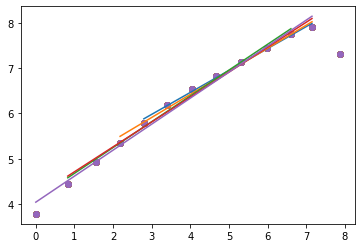

In [149]:
for selected_n_bins in range(8, n_bins):
    selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == selected_n_bins][0]
    line, slope, offset, error = trend_line(selected_bins)
    print('bins:', selected_n_bins, '\trent exponent:', '{:.2f}'.format(slope))
    # plt.vlines(log_bin_means[:,0], log_bin_means[:,1]-log_bin_stds, log_bin_means[:,1]+log_bin_stds, colors='pink')
    plt.scatter(log_bin_means[:,0], log_bin_means[:,1])

    plt.plot(line[:,0], line[:,1])


bins: 12 	rent exponent: 0.48


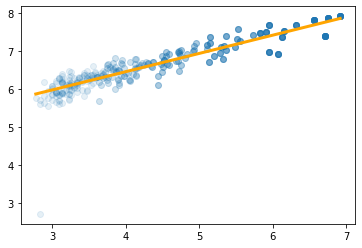

In [240]:
# plt.xscale("log")
# plt.yscale("log")
# plt.scatter(blocks, pins, alpha = 0.1)
# plt.scatter(bin_means[:,0], bin_means[:,1])
rent_data_trim = rent_data[2:8]
mult = np.flip(2**np.arange(len(rent_data_trim)))
rent_data_weighted_flat = []
for x, rent_data_level in zip(mult, rent_data_trim):
    rent_data_weighted_flat.extend(rent_data_level*x)
rent_data_weighted_flat = np.array(rent_data_weighted_flat)
log_rent_data_weighted_flat = np.log(rent_data_weighted_flat)
log_rent_data_weighted_flat = log_rent_data_weighted_flat[log_rent_data_weighted_flat[:, 0].argsort()]

line, slope, offset, error = trend_line(log_rent_data_weighted_flat)
print('bins:', selected_n_bins, '\trent exponent:', '{:.2f}'.format(slope))
plt.scatter(log_rent_data_weighted_flat[:,0], log_rent_data_weighted_flat[:,1],alpha = 0.11)

plt.plot(line[:,0], line[:,1], color='orange', linewidth=3)

In [150]:
print('Rent exponent:', slope)

Rent exponent: 0.5737231800128719


In [151]:
bins: 4 	rent exponent: 0.54
bins: 5 	rent exponent: 0.53
bins: 6 	rent exponent: 0.61
bins: 7 	rent exponent: 0.58
bins: 8 	rent exponent: 0.49

SyntaxError: invalid syntax (1851776032.py, line 1)

In [175]:
len(mult), len(rent_data[-4])

(14, 1024)

In [184]:
rent_data[2]*2

[[1014, 2731],
 [860, 2640],
 [823, 1637],
 [709, 2496],
 [1014, 2731],
 [860, 2640],
 [823, 1637],
 [709, 2496]]

In [214]:
len(rent_data_trim)

12

In [230]:
log_rent_data_weighted_flat

array([[0.        , 3.93182563],
       [0.        , 1.09861229],
       [0.        , 3.49650756],
       ...,
       [6.92165818, 7.91242312],
       [6.92165818, 7.91242312],
       [6.92165818, 7.91242312]])